The machinery provied here is designed to work with nequrla network models, and is overkill for a traditional sklearn type
[model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), as most of the necessary
functions to train and evaluate a model are provided within sklearn. If you wish to try our sample pre-processing 
steps with your favorite sklearn model, an example is provided within the notebooks directory. Using the
generated word embeddings and tokenized documents generated by our preprocessing script are incompatibe with
the sklearn library, which expects feature vectors as input, not higher dimensional inputs. We'll first import the reuqired libraries to get started.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gensim

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

Now we may use a sample version of our preprocessing pipeline to clean the text, removing non-alphanumeric characters, escape characters, and words shorter than 2 characters long.

In [2]:
imdb = pd.read_csv('../data/imdb/IMDB Dataset.csv')

data = [d.lower() for d in imdb['review']]
data = [gensim.parsing.preprocessing.strip_tags(d) for d in data]
data = [gensim.parsing.preprocessing.strip_non_alphanum(d) for d in data]
data = [gensim.parsing.preprocessing.strip_short(d, minsize=2) for d in data]

Since sklearn style methods are designed for vector inputs, we cannot use the tokenizer and word2vec embedding for the neural net pipeline. Instead, we may use the classic tf-idf algorithm to generate features for our model. We will also map the sentiment from strings to integer values for the classification algorithm.

In [3]:
vec = TfidfVectorizer()
X = vec.fit_transform(data)
y = imdb['sentiment'].map({'negative': 0, 'positive': 1})

As the last step prior to inference, we need to split the data into train and test sets. Here we chose a 90/10 split, but you may change this to suit your needs.

In [4]:
seed = 42
train_split = 0.90
test_split = 0.10
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=seed)

Now we may fit a model and make some predictions from the test set. We choose to get the prediction probabilities to match the analysis steps from the FrESCO library and any subsequent analysis. Note that this is not required and the `predict_proba` call could also be `predict` to obtain the predicted classes.

In [5]:
clf = LogisticRegression(random_state=seed, solver='sag').fit(x_train, y_train)
pred_probs = clf.predict_proba(x_test)
preds = np.argmax(pred_probs, axis=1)

We may now score our model and see how it did.

In [6]:
acc = accuracy_score(y_test, preds)
macro = f1_score(y_test, preds, average='macro')
micro = f1_score(y_test, preds, average='micro')

print(f"accuracy: {acc:8.6f}\nmacro: {macro:8.6f}\nmicro: {micro:8.6f}")

accuracy: 0.902200
macro: 0.902157
micro: 0.902200


IMDB Confusion Matrix
[[2203  278]
 [ 211 2308]]


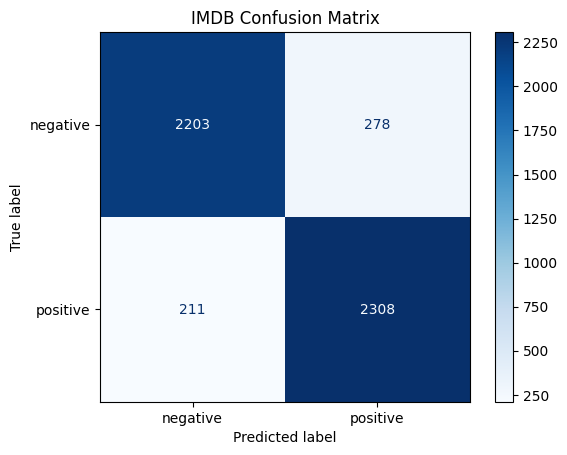

In [7]:
labels = ['negative', 'positive']
title = 'IMDB Confusion Matrix'

disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    x_test,
    y_test,
    display_labels=labels,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

So, we're not doing too bad with an out of the box model. The situation gets more complicated when we want to use either matrix (or tensor) valued features, or want to do multi-task classification, similar to the case in the P3B3 dataset. The sklearn models have some support for multitask learning, but considering the added development time, it might be worth considering a torch model within the training and evaluation framework provided here.